In [10]:
import lightgbm as lgb
from sklearn import metrics
import category_encoders as ce

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from xgboost import XGBRegressor

In [3]:
df = pd.read_csv('../data/train.csv',dtype={'tipodepropiedad':'category','ciudad':'category','provincia':'category'})
df['fecha'] = pd.to_datetime(df['fecha'])
df['anio'] = df['fecha'].dt.year
df["mes"] = df['fecha'].dt.month
df["dia"] = df['fecha'].dt.day

In [4]:
df = df.drop(columns=["lat","lng","direccion","id","descripcion","titulo"])

In [5]:
def imputar(df):
    imp = SimpleImputer()
    cols = df._get_numeric_data().columns
    df_result = df.copy()
    for x in cols:
        df_result[x]=imp.fit_transform(df[[x]])
    return df_result

In [6]:
df1 = imputar(df)

oneHot = [ 'tipodepropiedad','provincia']
label = ['ciudad']

cat_features = ['ciudad','tipodepropiedad','provincia']

df1 = df1.dropna(subset=cat_features)

In [7]:
def predecir(model, train_features, train_labels, test_features, test_labels):
    predict = model.score(test_features,test_labels)
    print('Entrenamiento: {:0.4f}%'.format(model.score(train_features, train_labels)*100))
    print('Testeo: {:0.4f}%.'.format(predict*100))
    
    return predict

In [20]:
data_cols = df1._get_numeric_data().columns
baseline_data = df1[data_cols]

encoder = ce.OneHotEncoder()

encoded = encoder.fit_transform(df1[oneHot])
data = baseline_data.join(encoded)

encoder = LabelEncoder()

encoded = encoder.fit_transform(df1[label])
data["ciudad"] = encoded

x = data[data.columns.drop("precio")]
y = data['precio']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30)

print(f"Original shapes: X={x.shape} y={y.shape}")
print(f"Train shapes: X={x_train.shape} y={y_train.shape}")
print(f"Test  shapes: X={x_test.shape}  y={y_test.shape}")

Original shapes: X=(239600, 72) y=(239600,)
Train shapes: X=(167720, 72) y=(167720,)
Test  shapes: X=(71880, 72)  y=(71880,)


In [22]:
xgb_model = XGBRegressor(n_estimatos=300,max_depth=13,n_jobs=-1,objective="reg:squarederror")


In [23]:
xgb_model.fit(x_train, y_train)

/home/peter/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=13, min_child_weight=1, missing=None, n_estimators=100,
             n_estimatos=300, n_jobs=-1, nthread=None,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=1, verbosity=1)

In [24]:
predecir(xgb_model,x_train,y_train,x_test,y_test)

Entrenamiento: 94.8908%
Testeo: 80.8454%.


0.8084539771120796

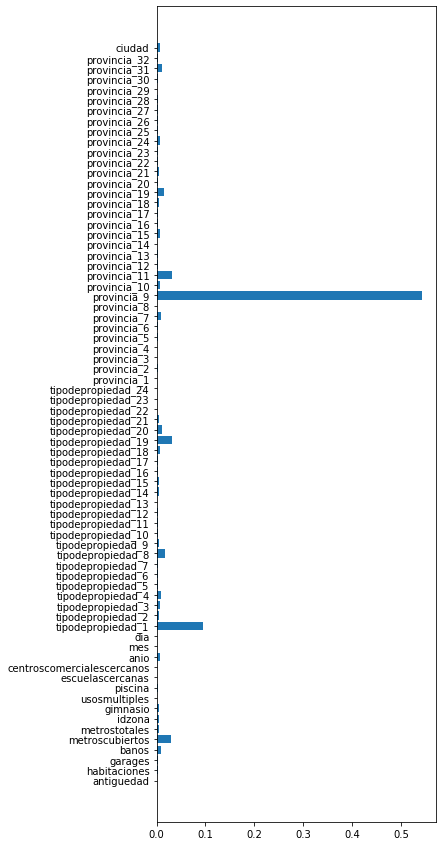

In [44]:
plt.rcParams["figure.figsize"] = [5, 15]

importancia = xgb_model.feature_importances_
ax = plt.barh(x.columns, xgb_model.feature_importances_)